# Dataset Exploration

We explore our dataset, driven by the following questions:

1. **How many comments does user X have?**
2. **What are typical times for comments? Given a user X, what time(s) are they commenting?**
3. **What channel(s) is user X commenting on?**
4. **How close to a video's upload time is user X commenting?**
5. **Are there perceived or underlying patterns in user X's comments?**

## 0. Setup

We connect to the Postgres container locally

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint

import sys
import os
from pathlib import Path

project_root = Path(os.getcwd()).parent if 'notebooks' in os.getcwd() else Path(os.getcwd())
sys.path.insert(0, str(project_root)) # Make root directory the cwd

from dotenv import load_dotenv
load_dotenv()

# Override Postgres env variables for local runtime
os.environ["POSTGRES_PORT"] = os.getenv("POSTGRES_PORT_LOCAL", 5555)
os.environ["POSTGRES_HOST"] = "localhost"

from src.data.psql import Psql

psql_client = Psql()

## 1. Querying comment counts based on user

In [63]:
psql_client.rollback()

In [37]:
query = """
SELECT u.username, u.userId, COUNT(c.commentId) AS commentCount
FROM Yt.Users AS u
JOIN Yt.Comments as c
    ON u.userId = c.commenterId
GROUP BY u.userId, u.username
HAVING COUNT(c.commentId) > 3
ORDER BY commentCount DESC;
"""

result = psql_client.query(query)
print("Top 10 commenters:\n")
for i in range(10):
    print(result[i])

Top 10 commenters:

('@88nlinus', 'UCZFhmduJg0xnWAKZTxLsEFQ', 69)
('@josephsonora3787', 'UC3XEpDanrCsH_k3yxkq_hZg', 64)
('@americanpatriot6484', 'UCg3mpGTW0LSm7ZTXHStTmkg', 64)
('@DawoodRehman-r5c', 'UCrpO2yRm9PeGB3LbYg6Roug', 64)
('@wethepeople7382', 'UCoHwVlGCKCfsYh_l9Y9mCPA', 63)
('@HandsomeKent', 'UCCQqgcQyleyNjgXAeywkNmQ', 60)
('@BillyJones-b4i6u', 'UCOFlYbL1XlJuUgUg8BOITaQ', 59)
('@MichaelBibula', 'UCAKggySl9ZdokP_q1GGvNSg', 57)
('@CnnLiesConstantly', 'UCDYQFG5CkxQFKG-cgD_vpBg', 57)
('@markcosenza3274', 'UCyQwpzdUBWaUjStqO9qrX9Q', 57)


## 2. Finding times of comments of a particular user

Let's observe the times of **@Michael-z5t3h**'s comments

In [61]:
def get_user_comment_distribution(user_id: str):
    query = """
    SELECT c.publishDate AS commentHour
    FROM Yt.Comments AS c
    WHERE c.commenterId = %s;
    """
    comment_times = psql_client.query(query, (user_id,))
    comment_times = [time[0] for time in comment_times]
    
    df = pd.DataFrame({'datetime': comment_times})
    df['datetime'] = pd.to_datetime(df['datetime'])
    return df

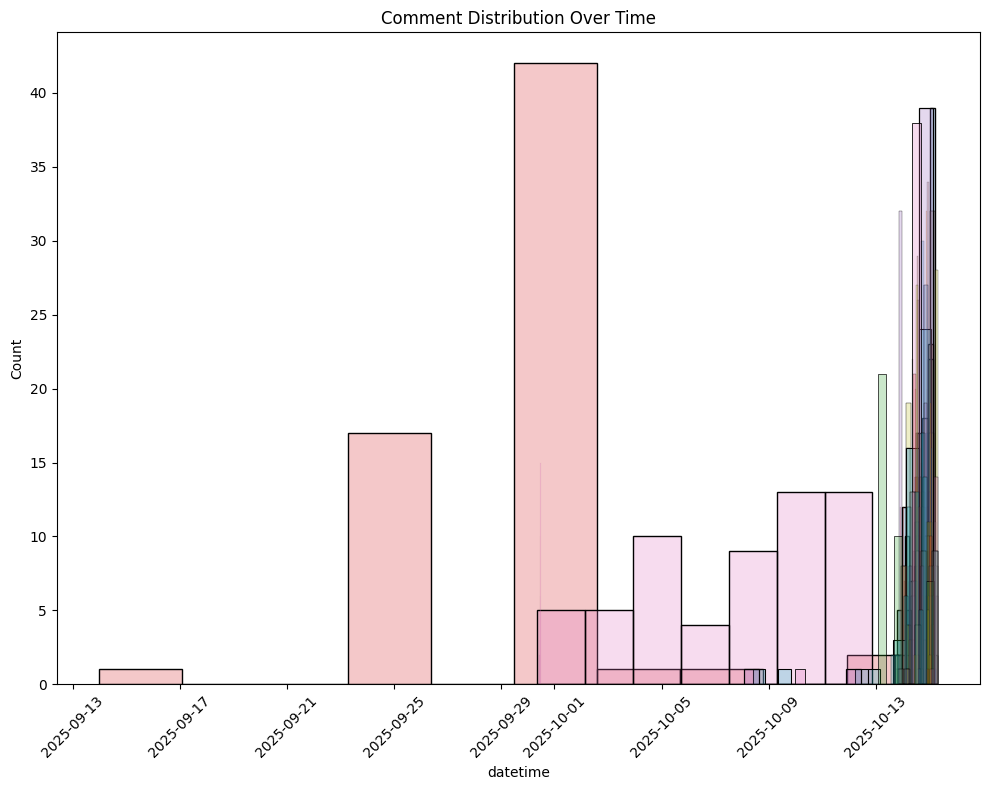

In [64]:
plt.figure(figsize=(10,8))

for i in range(50):
    user_id = result[i][1]
    df = get_user_comment_distribution(user_id)
    
    sns.histplot(data=df, x='datetime', alpha=0.25, label=user_id)

plt.xticks(rotation=45)
plt.title('Comment Distribution Over Time')
plt.tight_layout()
plt.show()

Right now, this is purely raw datetimes. It might be more insightful to get the distributions of the hour of day these users are commenting

In [34]:
def get_user_hour_distribution(user_id):
    df = get_user_comment_distribution(user_id)
    df["hour"] = df["datetime"].dt.hour
    
    return pd.DataFrame(df["hour"])

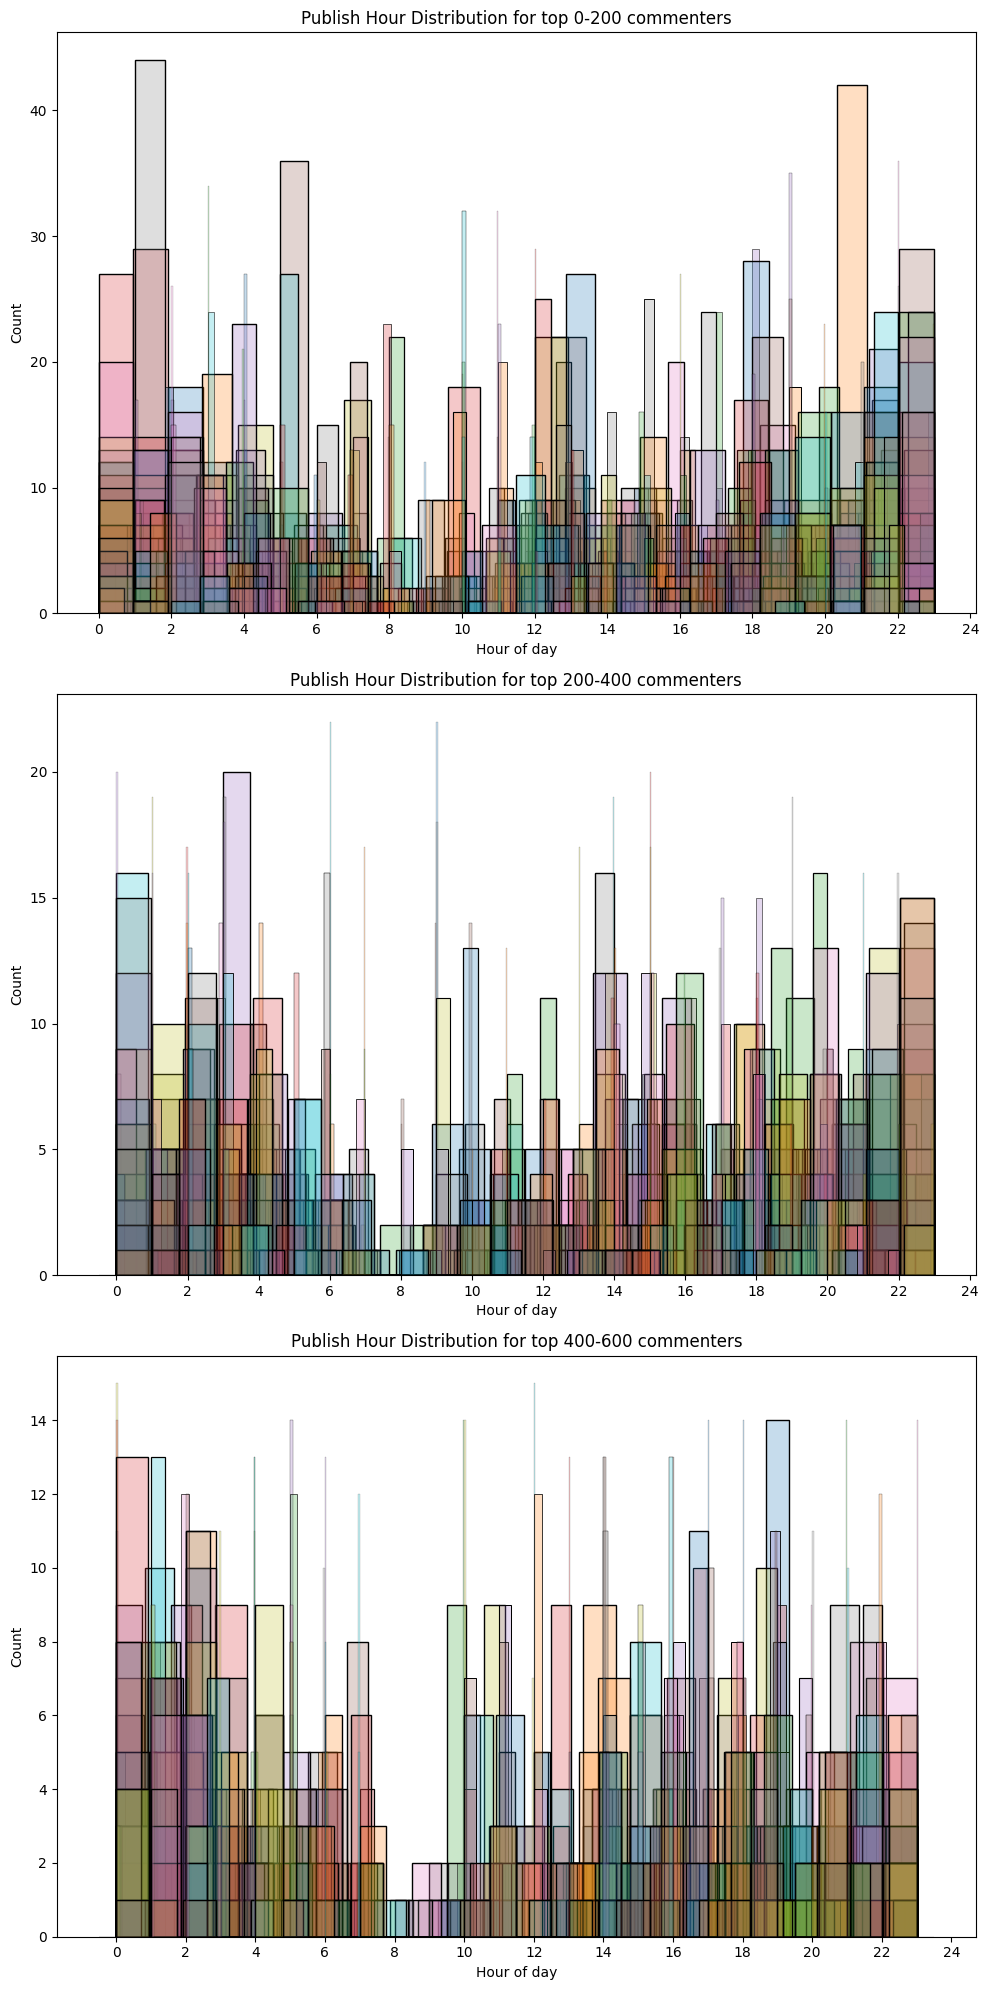

In [51]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 20))


for i in range(3):
    for j in range(200*i, 200*(i+1)):
        user_id = result[j][1]
        df = get_user_hour_distribution(user_id)
        sns.histplot(data=df, x="hour", bins=24, alpha=0.25, label=user_id, ax=axes[i])
    
    axes[i].set_xlabel("Hour of day")
    axes[i].set_xticks(np.arange(0, 25, 2))
    axes[i].set_title(f"Publish Hour Distribution for top {200 * i}-{200*(i+1)} commenters")

plt.tight_layout()
plt.show()
    

We see local peaks of activity around 12:00 UTC (roughly morning time) and around 22:00-24:00 UTC (roughly evening/night time), representing a typical worker's day job schedule.

We can observe a general dip in comment frequency, which likely represents usual sleeping hours. However, there are some visible outliers, shown by the thin bars around hours 6-12

We also see some slight distributional differences, where the 400-600th commenters have a more pronounced

We can explore 'deviance' from the typical activity time below:

In [26]:
query = """
SELECT c.commenterId, EXTRACT(HOUR FROM c.publishDate)::INTEGER
FROM Yt.Comments AS c;
"""

df = pd.DataFrame(psql_client.query(query), columns=["userId", "commentHour"])

df["radians"] = df["commentHour"] * (2 * np.pi / 24)
sin_mean = np.mean(np.sin(df["radians"]))
cos_mean = np.mean(np.cos(df["radians"]))

circular_mean_radians = np.arctan2(sin_mean, cos_mean)
circular_mean_hour = (circular_mean_radians * 24 / (2 * np.pi)) % 24

R = np.sqrt(sin_mean**2 + cos_mean**2)
circular_variance = 1 - R

print(f"Average comment hour: {circular_mean_hour}")
print(f"Comment hour variance: {circular_variance}")

Average comment hour: 22.55944185140222
Comment hour variance: 0.8004953419868557


In [27]:
def get_hour_difference_from_mean(hr, circular_mean_hour = circular_mean_hour):
    return min((hr - circular_mean_hour) % 24, (circular_mean_hour - hr) % 24)

In [28]:
query = """
SELECT commenterId, hour
FROM (
    SELECT c.commenterId, EXTRACT(HOUR FROM c.publishDate)::INTEGER AS hour
    FROM Yt.Comments AS c
) AS hours
WHERE commenterId IN (
    SELECT commenterId
    FROM Yt.Comments
    GROUP BY commenterId
    HAVING COUNT(*) >= 10  -- threshold
);
"""

result = pd.DataFrame(psql_client.query(query), columns=["userId", "commentHour"])
result["radians"] = result["commentHour"] * (2 * np.pi / 24)

# Group by user and calculate circular mean for each
user_circular_stats = result.groupby("userId").apply(
    lambda group: pd.Series({
        'sin_mean': np.mean(np.sin(group["radians"])),
        'cos_mean': np.mean(np.cos(group["radians"])),
        'comment_count': len(group)
    }), include_groups=False
).reset_index()

# Calculate circular mean hour and variance
user_circular_stats["circular_mean_rad"] = np.arctan2(
    user_circular_stats["sin_mean"], 
    user_circular_stats["cos_mean"]
)
user_circular_stats["circular_mean_hour"] = (
    user_circular_stats["circular_mean_rad"] * 24 / (2 * np.pi)
) % 24

user_circular_stats["R"] = np.sqrt(
    user_circular_stats["sin_mean"]**2 + user_circular_stats["cos_mean"]**2
)
user_circular_stats["circular_variance"] = 1 - user_circular_stats["R"]

In [29]:
user_circular_stats["deviance"] = user_circular_stats["circular_mean_hour"].apply(
    lambda hour: get_hour_difference_from_mean(hour, circular_mean_hour)
)

user_circular_stats.sort_values(by="deviance", ascending=False).head(5)

,userId,sin_mean,cos_mean,comment_count,circular_mean_rad,circular_mean_hour,R,circular_variance,deviance
568,UCXJKaA-iUjowh386J9IHl_Q,0.356371,-0.913330,24.0,2.769572,10.578987,0.980394,0.019606,11.980455
983,UCv3u3iQ9SqP_0_o6WjTE_qQ,0.370133,-0.919818,13.0,2.759020,10.538681,0.991496,0.008504,11.979240
1032,UCyQwpzdUBWaUjStqO9qrX9Q,0.346379,-0.909129,57.0,2.777572,10.609542,0.972879,0.027121,11.949900
677,UCcs0yVIeUZn397D50ylyB8w,0.320212,-0.767796,12.0,2.746472,10.490751,0.831893,0.168107,11.931309
3,UC-E_u0tONL7jX233EX8yy1A,0.384873,-0.900653,28.0,2.737753,10.457445,0.979440,0.020560,11.898003


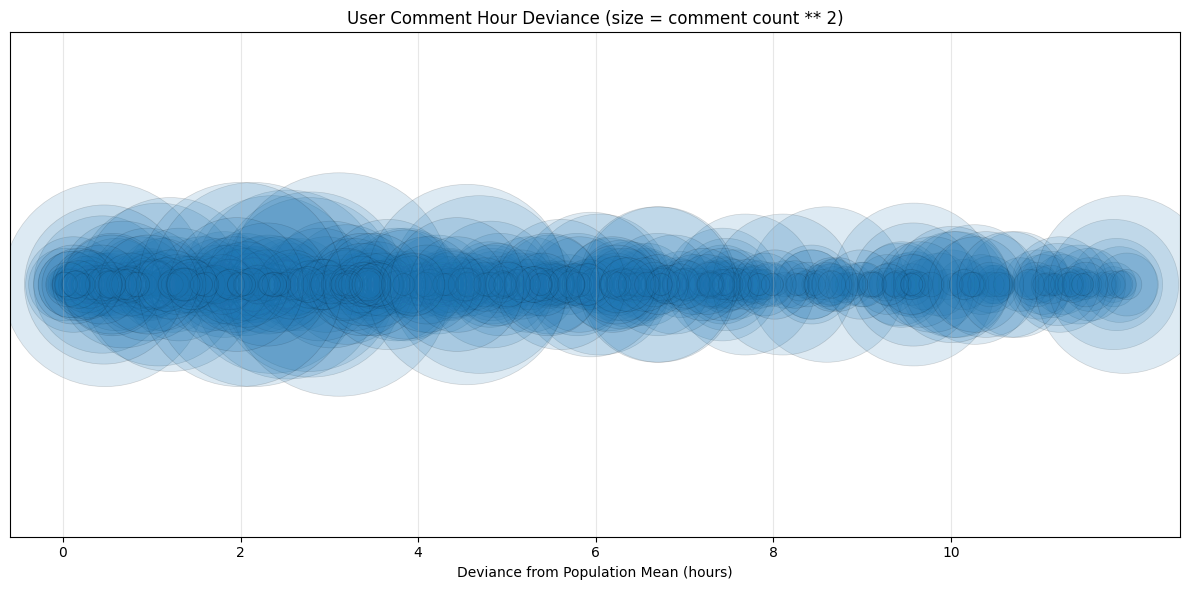

In [119]:
plt.figure(figsize=(12,6))

plt.scatter(
    x=user_circular_stats["deviance"],
    y=np.zeros(len(user_circular_stats)),
    s=user_circular_stats["comment_count"] ** 2.4,
    alpha=0.15,
    edgecolors="black",
    linewidths=0.5
)

plt.xlabel("Deviance from Population Mean (hours)")
plt.ylabel("")
plt.yticks([])
plt.xticks(np.arange(0, 12, 2))
plt.title("User Comment Hour Deviance (size = comment count ** 2)")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/qh/zp3sqlm15lj3hm8lhm_7340h0000gp/T/ipykernel_4263/3191337048.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left")


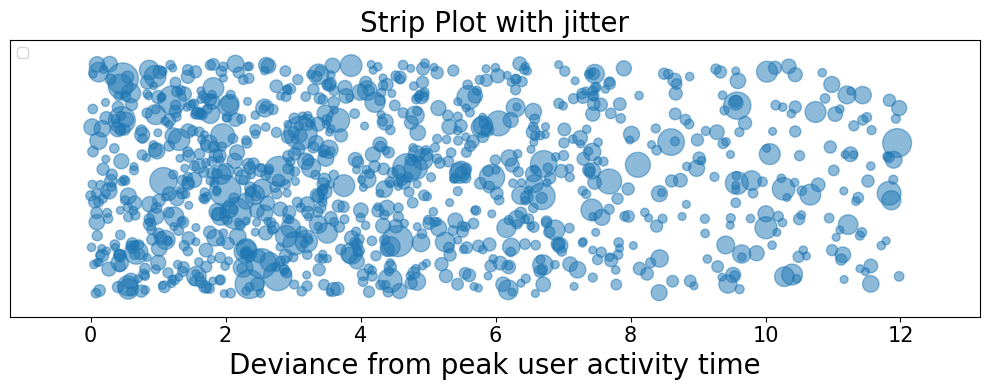

In [32]:
plt.figure(figsize=(10,4))

plt.scatter(
    user_circular_stats["deviance"], 
    np.random.uniform(-0.1, 0.1, len(user_circular_stats)),  # Add jitter
    s=user_circular_stats["comment_count"] ** 1.5,
    alpha=0.5
)
plt.margins(x=0.1, y=0.1)
plt.title("Strip Plot with jitter", fontsize=20)
plt.legend(loc="upper left")
plt.yticks([])
plt.xticks(fontsize=15)
plt.xlabel("Deviance from peak user activity time", fontsize=20)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Comment count')

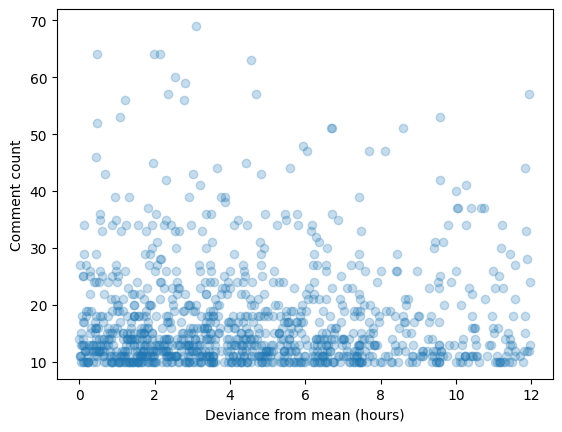

In [162]:
plt.scatter(
    user_circular_stats["deviance"],
    user_circular_stats["comment_count"],
    alpha=0.25
)
plt.xlabel("Deviance from mean (hours)")
plt.ylabel("Comment count")

## 3. Comment Speed

We would also want to observe how quickly users are commenting upon video publishing.

We filter out uploads within the last 24 hours to allow for a more

In [115]:
psql_client.rollback()

In [17]:
commentLatencyQuery = """
SELECT c.commenterId,
    AVG(EXTRACT(EPOCH FROM (c.publishDate - v.publishDate)) / 60) AS meanLatencyMinutes,
    STDDEV(EXTRACT(EPOCH FROM (c.publishDate - v.publishDate)) / 60) AS stdevLatencyMinutes
FROM YT.Comments AS c
JOIN Yt.Videos AS v
    ON c.videoId = v.videoId
GROUP BY c.commenterId
HAVING COUNT(c.commenterId) > 1
    AND AVG(EXTRACT(EPOCH FROM (c.publishDate - v.publishDate)) / 60) > 0
ORDER BY meanLatencyMinutes ASC;
"""

meanLatencyQuery = f"""
SELECT l.commenterId, AVG(l.commentLatencyMinutes)
FROM ({commentLatencyQuery}) AS l
GROUP BY l.commenterId;
"""

comment_video = psql_client.query(commentLatencyQuery)


In [18]:
comment_video[:4]

[('UCCZ4bm09FMHDQHntgwv2AQA',
  Decimal('0.40000000000000000000'),
  Decimal('0.0471404520791031682886755789324129524563')),
 ('UCzVZxF8kZCQhUe60PaGXXeQ',
  Decimal('0.87500000000000001667'),
  Decimal('0.2003469213361884888194889647519131995736')),
 ('UCFh4RCW5H9B7XKG0cYCcxWQ',
  Decimal('1.5611111111111111'),
  Decimal('0.31016721893795242692262029196715')),
 ('UCqVR7Uhw-EAkRwbKNr3BP0g',
  Decimal('1.5666666666666667'),
  Decimal('0.02357022603955156057646877251868'))]

## 4. Finding "Communities" of Commenters Across Videos

We would like to observe if there are specific communities of users who contribute to similar videos.

We look to the Louvain method ([Wikipedia article](https://en.wikipedia.org/wiki/Louvain_method)) to calculate communities.

We represent our graph as follows:

- Vertices: Videos or Users
- Edges: An undirected edge (u,v) exists if user u has a comment in video v



In [2]:
import networkx as nx
from networkx.algorithms import bipartite
from random import sample

In [3]:
# Get user-video pairs
query = """
SELECT DISTINCT c.commenterId, c.videoId
FROM Yt.Comments AS c;
"""
# Get subsample of pairs (full dataset blows up our memory
#   when we compute the communities)
pairs = sample(psql_client.query(query), k=80000)


In [4]:
# Get users and videos
users = list(set(pair[0] for pair in pairs))
videos = list(set(pair[1] for pair in pairs))

In [7]:
G = nx.Graph()
G.add_nodes_from(users, bipartite=0)
G.add_nodes_from(videos, bipartite=1)
G.add_edges_from(pairs)
print("Constructed graph")


# Project to user graph
user_graph = bipartite.weighted_projected_graph(G, users)
print("Projected to user graph")

# Detect communities
communities = nx.community.louvain_communities(user_graph, resolution=0.3)
print("Finished running Louvain algorithm")

Constructed graph
Projected to user graph
Finished running Louvain algorithm


In [8]:
[len(communities[i]) for i in range(len(communities))]

[456, 13755, 1992, 8867, 381, 390, 5029, 1152, 14544, 4, 1, 18953, 453]

In [19]:
query = """
SELECT c.commentText, u.username, v.title, c.publishDate
FROM Yt.Comments AS c
JOIN Yt.Users AS u
    ON u.userId = c.commenterId
JOIN Yt.Videos AS v
    ON c.videoId = v.videoId
WHERE c.commenterId IN %s;
"""
community_comments = psql_client.query(query, (tuple(communities[5]),))
df = pd.DataFrame(community_comments, columns=["commentText", "username", "videoTitle", "datetime"])
df.head()

,commentText,username,videoTitle,datetime
0,"They lie at press conferences, so why even sig...",@MochaMouse7,Media outlets refuse to sign Pete Hegseth’s ne...,2025-10-14 23:12:37
1,He is the Anne Coulter of the current Performa...,@Mac-ix4qp,Scott Jennings removes hostage pin after 2 yea...,2025-10-15 00:25:23
2,I pray for the redemption of his soul and that...,@Fr.MarioMagana,"Erika Kirk: Mr. President, you have given him ...",2025-10-15 04:13:15
3,But it is! The Ego in Chief loves to spread th...,@Fr.MarioMagana,"Erika Kirk: Mr. President, you have given him ...",2025-10-15 04:15:31
4,That's the only kind of affirmation we need!,@vueport99,NEW: Trump's major WARNING to Hamas after retu...,2025-10-15 01:08:03


## 5. Finding Duplicate Comments

In [21]:
query = """
SELECT c.commenterId, c.commentText, COUNT(*) AS count
FROM Yt.Comments AS c
GROUP BY c.commenterId, c.commentText
HAVING COUNT(*) > 1
ORDER BY count DESC;
"""
duplicate_comments = psql_client.query(query)
print("Example duplicate comments:\n")
for i in range(5):
    print(duplicate_comments[i])
print()

query2 = f"""
SELECT commenterId, COUNT(*) AS duplicateCount
FROM (
    {query.strip("\n;")}
)
GROUP BY commenterId
ORDER BY duplicateCount DESC;
"""
user_duplicate_count = psql_client.query(query2)
print("Top 5 users based on unique copy-pasted comments:\n")
for i in range(5):
    print(user_duplicate_count[i])

Example duplicate comments:

('UCQANb2YPwAtK-IQJrLaaUFw', 'Independent media has never been more important. Please support this channel by subscribing here: www.youtube.com/briantylercohen', 34)
('UCDqLSztdEKhWwPBla9kaTaA', 'Well, get ready to enjoy prison!!  You fraudulently listed your dad as your husband and your VA property as your primary residence, all to obtain better loan terms and that IS mortgage fraud!!  And you are also guilty of tax fraud and likely insurance fraud as well!!  Meanwhile, liberals will continue to post their love and support for this person they have never met simply because they h8 another person they also have never met!! Remember your favorite mantra, “no one is above the law”!!', 23)
('UCcrqVQmqZOuBNl1-O64JD_w', 'Thank you so much for supporting and engaging with my son’s report. Your feedback and encouragement mean a lot! Where are you tuning in from?', 23)
('UCUCn5RLzBPoyl8kB-0OYE6Q', 'TDSNOW+ BREAKING NEWS: Greta Van Doomsberg Unemployed On EBT After 

In [14]:
query = """
SELECT c.commentText, COUNT(*) AS count
FROM Yt.Comments AS c
WHERE c.commenterId = %s
GROUP BY c.commenterId, c.commentText
HAVING COUNT(*) > 1
ORDER BY count DESC;
"""

user_duplicate_comments = psql_client.query(query, (user_duplicate_count[0][0],))

df = pd.DataFrame(user_duplicate_comments, columns=["commentText", "numDuplicates"])
df

,commentText,numDuplicates
0,MSNBC is a racist News Network,6
1,Democrats have mental health issues,5
2,Democrat meltdown \nThank you President Trump,3
3,Snowflake is getting mad,3
4,Democrat meltdown \nDemocrats support Hamas \n...,3
5,​@@marketads1snowflake is getting mad,2
6,Ok snowflake,2
7,Thank you President Trump,2
8,Democrats are a joke,2
9,Democrats are a threat to Democracy,2
